In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy.stats as sp
from numba import guvectorize
from dspeed.utils import numba_defaults_kwargs as nb_kwargs

# LEGEND specific imports
from lgdo import lh5, VectorOfVectors, WaveformTable, Table, ArrayOfEqualSizedArrays, Array
from lgdo.lh5 import LH5Store
from dspeed import build_dsp
from dspeed.vis import WaveformBrowser

# MISC
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import glob

In [2]:
from dspeed.processors import optimize_nnls as nnls
from dspeed.processors import inject_gumbel
from pygama.pargen.dsp_optimize import run_one_dsp

In [3]:
# we'll just use basic white noise as the basis of our waveforms, this is slightly different to the 
# waveform data we have where the lower frequencies are higher
mean = 0
std = 20
num_samples = 1000 # number of waveforms
wf_len = 32 #the number of points in the wavefunction
samples = np.random.normal(mean, std, size=(num_samples, wf_len))
#this create white noise


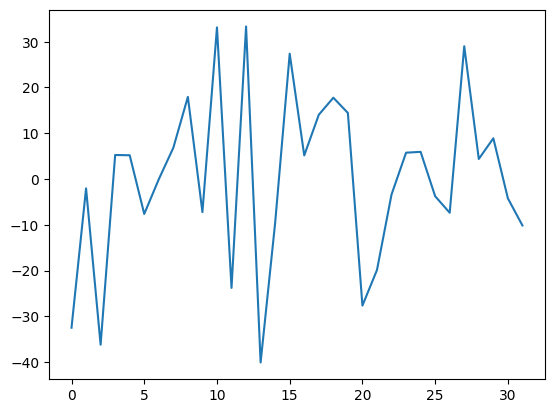

In [4]:
plt.figure()
plt.plot(samples[0,:])
plt.show()

In [5]:
# initialise the output object
wfs = np.zeros_like(samples)

In [6]:
# fix amplitude and width, vary t0 using uniform distribution
amplitude = 1000 #the bigger the amplitude, the clearer the peak. a small amplitude (>500) leads to an unclear peak. 
width = 1 #the smaller the width, the clearer the peak. a big width (>1.5) leads to an unclear peak.
t0_start = 11
shift = 5
t0s = np.random.uniform(t0_start,t0_start+shift,num_samples) #this indicates where the gumbel peak starts

In [7]:
for i in range(num_samples):
    inject_gumbel(samples[i,:], amplitude, t0s[i], width, wfs[i,:]) 

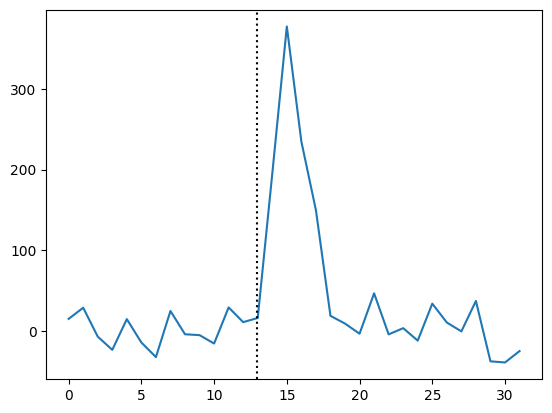

In [8]:
plt.figure()
plt.plot(wfs[100,:])
plt.axvline(t0s[100], color="black", ls=":")
plt.show()

In [9]:
def build_template_waveform(wfs_in, ts, upsample_factor=5):
    # Initialize extended arrays
    wf_len = len(wfs_in[0])
    wf_extended = np.zeros(wf_len * upsample_factor)
    counts = np.zeros(wf_len * upsample_factor)
    base = np.arange(wf_len)
    
    t0_shift = int(wf_len)/4
    shifts_list = np.floor((ts-t0_shift)*upsample_factor).astype(int)

    shifts = shifts_list[:, None]  # Shape (num_waveforms, 1) for broadcasting
    indices = base * upsample_factor - shifts  # Shape (num_waveforms, wf_len)
    
    # Scatter-add values to wf_extended and counts
    for i in range(num_samples):
        wf_extended[indices[i]] += wfs_in[i,:]
        counts[indices[i]] += np.ones(wf_len)
    
    start = int(t0_shift * upsample_factor)
    start_value = (wf_extended / counts)[start]
    end = int(np.ceil((np.where((wf_extended / counts)[start:] <start_value)[0][0] + start) /upsample_factor ) * upsample_factor)

    # Plot the result
    plt.figure()
    plt.plot(wf_extended / counts)
    plt.xlim([start,end])
    plt.show()

    return (wf_extended / counts)[start:end]

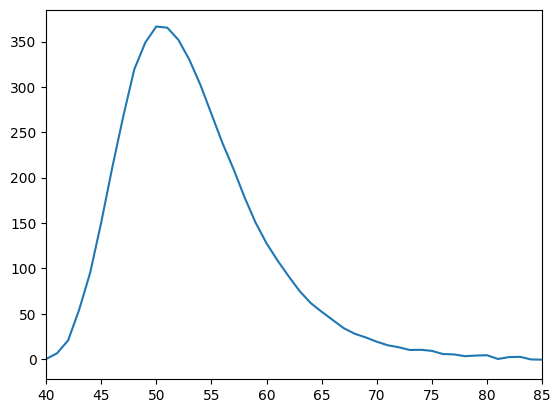

In [10]:
wf_template = build_template_waveform(wfs, t0s, 5)

In [11]:
num_tests = 100
test_wfs = np.random.normal(mean, std, size=(num_tests, wf_len))
test_t0s = np.random.uniform(t0_start,t0_start+shift,num_tests) #this indicates where the gumbel peak starts
for i in range(num_tests):
     inject_gumbel(test_wfs[i,:], amplitude, test_t0s[i], width, test_wfs[i,:])

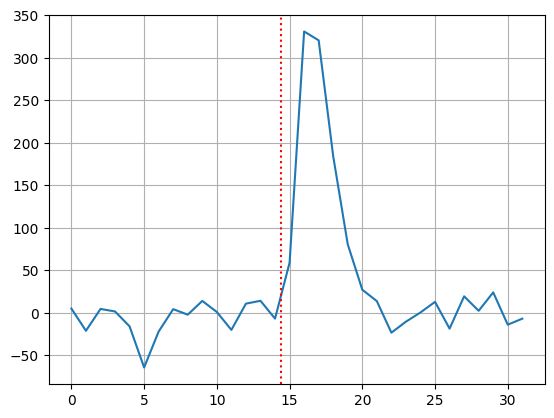

In [12]:
plt.figure()
i=1
plt.plot(test_wfs[i])
plt.axvline(test_t0s[i], color="red", ls = ":")
plt.grid()
plt.show()

In [14]:
upsample = 5
out_len = wf_len*upsample
# Initialize A matrix , is it worth constraining so full template must be present?
t0_trials = np.arange(0,wf_len,1/upsample)

In [15]:
from scipy.linalg import hankel

In [16]:
padded_template = np.zeros(out_len)
padded_template[:len(wf_template)] = wf_template

In [17]:
A_upsampled = hankel(padded_template[::-1],np.full(len(padded_template),0))[::-1,:]
A_upsampled = A_upsampled.astype("float32")

In [18]:
charge_trials = np.sum(A_upsampled, axis =0)

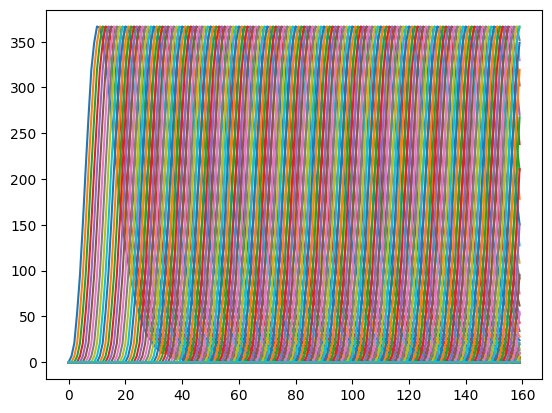

In [19]:
plt.figure()
plt.plot(A_upsampled)
plt.show()

In [20]:
sampling = np.zeros(out_len, dtype=bool)
sampling[np.arange(0,out_len,upsample, dtype=int)] = True
A = A_upsampled[sampling]

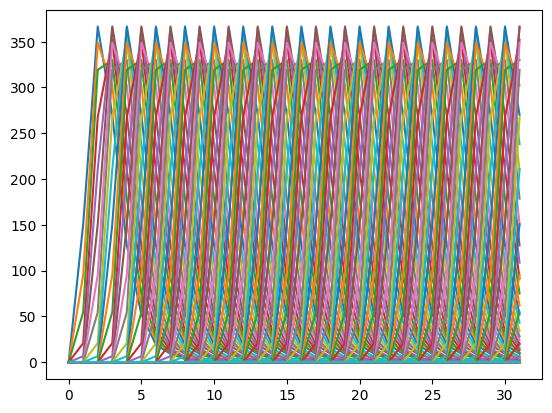

In [21]:
plt.figure()
plt.plot(A)
plt.show()

In [22]:
out = np.zeros(160)

In [23]:
# Run NNLS
nnls(A, test_wfs[0], 2000, 1e-6, False, out)

()

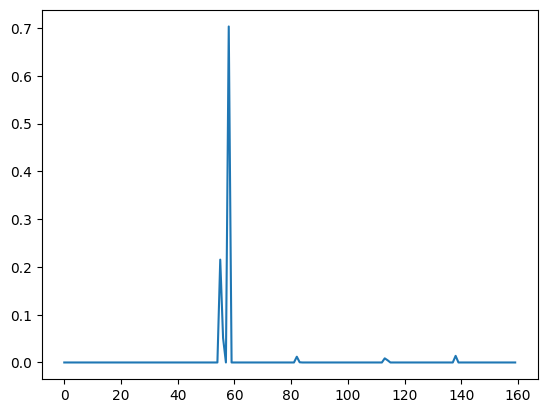

In [24]:
plt.figure()
plt.plot(out)
plt.show()

* could suppress all below some threshold e.g. 0.1/0.2?
* can define t0 here using the maximum.
    * how would this work with pileup?
* compare t0 to injected t0

In [25]:
zres = np.zeros(out_len)
for i in range(out_len):
    zres += out[i] * A_upsampled[:,i]
t0_est = t0_trials[np.argmax(out)]

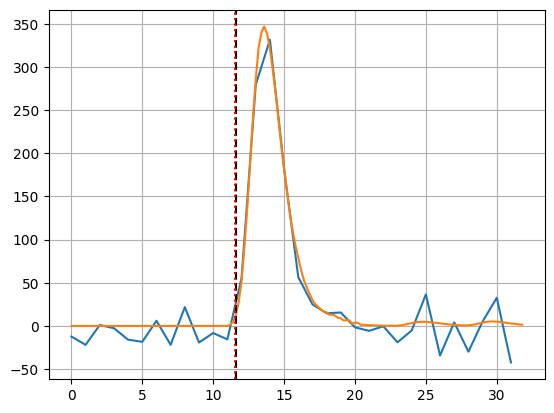

In [26]:
plt.figure()
plt.plot(test_wfs[0])
plt.plot(np.arange(0,out_len,1)/upsample, zres)
plt.axvline(t0_est, color="black", ls = "--")
plt.axvline(test_t0s[0], color="red", ls = ":")
plt.grid()
plt.show()

In [54]:
b = WaveformTable(values=test_wfs,dt=5,dt_units="ns",t0=0,t0_units="ns")
    
# add everything into a lh5 structure and write it to disk
table = Table(size=len(b))
table.add_field("waveform",b,True)

In [55]:
table

Table(dict={'waveform': WaveformTable(dict={'t0': Array([0. 0. ... 0. 0.], attrs={'datatype': 'array<1>{real}', 'units': 'ns'}), 'dt': Array([5. 5. ... 5. 5.], attrs={'datatype': 'array<1>{real}', 'units': 'ns'}), 'values': ArrayOfEqualSizedArrays([[-12.23820549 -21.84968407 ... 32.71493064 -42.28479658] [ 5.13871787 -20.99414227 ... -13.81255093 -6.7165056 ] ... [ 5.84038103 -34.22230161 ... 16.13983362 -2.84417214] [ -5.5991369 17.10141678 ... 11.9750766 -7.85335267]], attrs={'datatype': 'array_of_equalsized_arrays<1,1>{real}'})}, attrs={'datatype': 'table{t0,dt,values}'})}, attrs={'datatype': 'table{waveform}'})

In [2]:
config = {
    "outputs": [
        "wf_blsub",
        "tp_max",
        "wf_max",
        "nnls_solution",
        "wf_upsampled",
        "t0"
    ],
    "processors":{
        "tp_min, tp_max, wf_min, wf_max": {
            "description": "find waveform max and min and the corresponding timepoints",
            "function": "min_max",
            "module": "dspeed.processors",
            "args": ["wf_blsub", "tp_min", "tp_max", "wf_min", "wf_max"],
            "unit": ["ns", "ns", "ADC", "ADC"]
        },
        "bl_mean , bl_std, bl_slope, bl_intercept": {
          "description": "finds mean and rms of waveform initial samples",
          "function": "linear_slope_fit",
          "module": "dspeed.processors",
          "args": [
            "waveform[0: 5]",
            "bl_mean",
            "bl_std",
            "bl_slope",
            "bl_intercept"
          ],
          "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
       "wf_blsub": {
           "description": "subract baseline from waveform",
            "function": "subtract",
            "module": "numpy",
            "args": ["waveform", "bl_mean", "wf_blsub"],
            "unit": "ADC",
        },
        "nnls_solution": {
            "function": "optimize_nnls",
            "module": "dspeed.processors",
            "args": ["db.coefficient_matrix",
                "wf_blsub",
                "1000", "1e-6", "True",
                "nnls_solution(db.solution_vector_length, period=db.solution_vector_resolution_in_ns*ns)"],
            "unit": "ADC/sample"
        },
        "wf_upsampled": {
           "description": "get upsampled waveform",
            "function": "matmul",
            "module": "numpy",
            "args": [
                "nnls_solution", 
                "db.upsampled_matrix", 
                "wf_upsampled(db.solution_vector_length, period = db.solution_vector_resolution_in_ns*ns)"
            ],
            "unit": "ADC",
            "kwargs": { "signature": "(n),(n,n)->(n)", "types": ["dd->d"] },
        },
        "tp_min_up, tp_max_up, wf_min_up, wf_max_up": {
            "description": "find waveform max and min and the corresponding timepoints",
            "function": "min_max",
            "module": "dspeed.processors",
            "args": ["wf_upsampled", "tp_min_up", "tp_max_up", "wf_min_up", "wf_max_up"],
            "unit": ["ns", "ns", "ADC", "ADC"]
        },
        "t0": {
          "description": "walks backwards through asymmetric trap convolved waveform until below threshold which defines t0",
          "function": "time_point_thresh",
          "module": "dspeed.processors",
          "args": ["wf_upsampled", "5", "tp_max_up", 0, "t0"],
          "unit": "ns"
        }
        
    }
}



In [3]:
import yaml

In [5]:
with open("../src/mint-analysis/dsp/dsp_config.yaml", "w") as w:
    yaml.dump(config, w, sort_keys=False)

In [93]:
tb_out = run_one_dsp(
    table, 
    config,
    db_dict = {
        "coefficient_matrix":A,
        "upsampled_matrix":A_upsampled.T,
        "solution_vector_length": out_len, 
        "solution_vector_resolution_in_ns": 1, 
    }
)

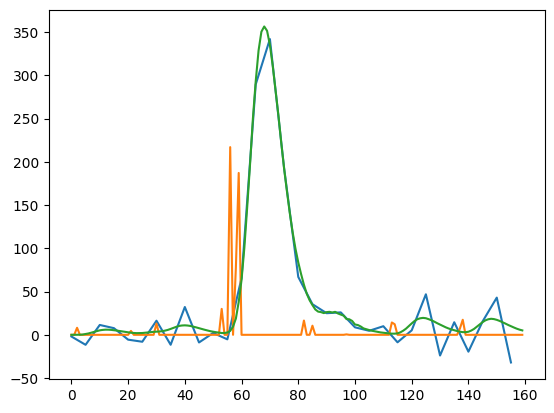

In [98]:
plt.figure()
plt.plot(np.arange(0,wf_len,1)*5, tb_out["wf_blsub"]["values"].nda[0])#/ np.nanmax(tb_out["wf_blsub"]["values"].nda[0])
plt.plot(tb_out["nnls_solution"]["values"].nda[0]*500)
plt.plot(tb_out["wf_upsampled"]["values"].nda[0])
plt.show()

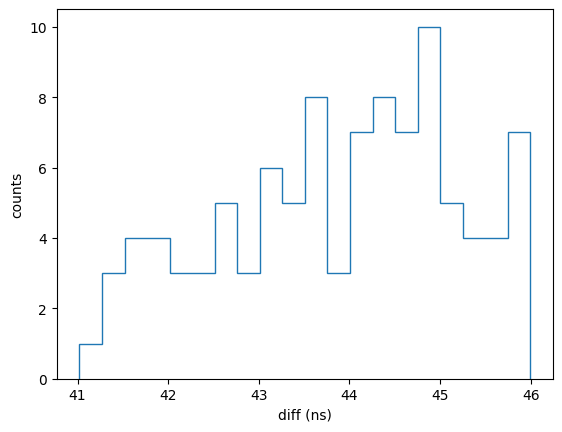

In [96]:
plt.figure()
plt.hist((tb_out["t0"].nda[0]-test_t0s), bins=20, histtype="step")
plt.xlabel("diff (ns)")
plt.ylabel("counts")
plt.show()

In [97]:
tb_out["t0"].nda[0]

57.0